In [1]:
import warnings
warnings.filterwarnings('ignore')
from evaluate_interpretability2 import *
import cebra
import os

In [2]:
embedding_size = 16
rat = 'buddy'

In [3]:
z_train = np.load(f"../final_embeddings/output_dimension_{embedding_size}_{rat}/train_embeddings.npy")
z_valid = np.load(f"../final_embeddings/output_dimension_{embedding_size}_{rat}/valid_embeddings.npy")

ds = cebra.datasets.hippocampus.SingleRatDataset(name=rat, root='../data', download=True)

labels = ds.continuous_index.numpy()
split_idx = int(0.8 * len(ds.neural))
position_train = labels[:split_idx, 0]
position_valid = labels[split_idx:, 0]

direction_train = np.argmax(labels[:split_idx, 1:], axis=1)
direction_valid = np.argmax(labels[split_idx:, 1:], axis=1)

neural_train = ds.neural[:split_idx].numpy()
neural_valid = ds.neural[split_idx:].numpy()

In [4]:
r2_train = compute_position_r2(z_train, position_train)
r2_valid = compute_position_r2(z_valid, position_valid)
print(f"Position R2 — train: {r2_train:.3f}, valid: {r2_valid:.3f}")

Position R2 — train: 0.575, valid: 0.675


In [5]:
acc_train = compute_direction_acc(z_train, direction_train)
acc_valid = compute_direction_acc(z_valid, direction_valid)
print(f"Direction acc — train: {acc_train:.3f}, valid: {acc_valid:.3f}")

Direction acc — train: 0.759, valid: 0.880


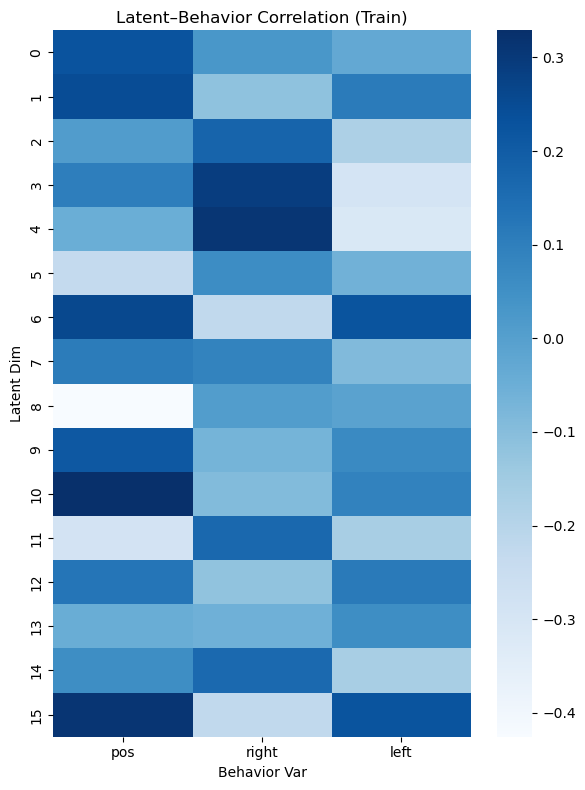

In [6]:
behavior_train = np.stack([position_train, direction_train == 1, direction_train == 0], axis=1)
corr = compute_behavior_corr(z_train, behavior_train)

plt.figure(figsize=(6, 8))
sns.heatmap(corr, cmap="Blues", xticklabels=["pos", "right", "left"])
plt.title("Latent–Behavior Correlation (Train)")
plt.xlabel("Behavior Var")
plt.ylabel("Latent Dim")
plt.tight_layout()
plt.show()

In [7]:
sparsity_percent = compute_sparsity(z_train)
print(f"Avg % active dims: {sparsity_percent:.1f}%")

Avg % active dims: 99.7%


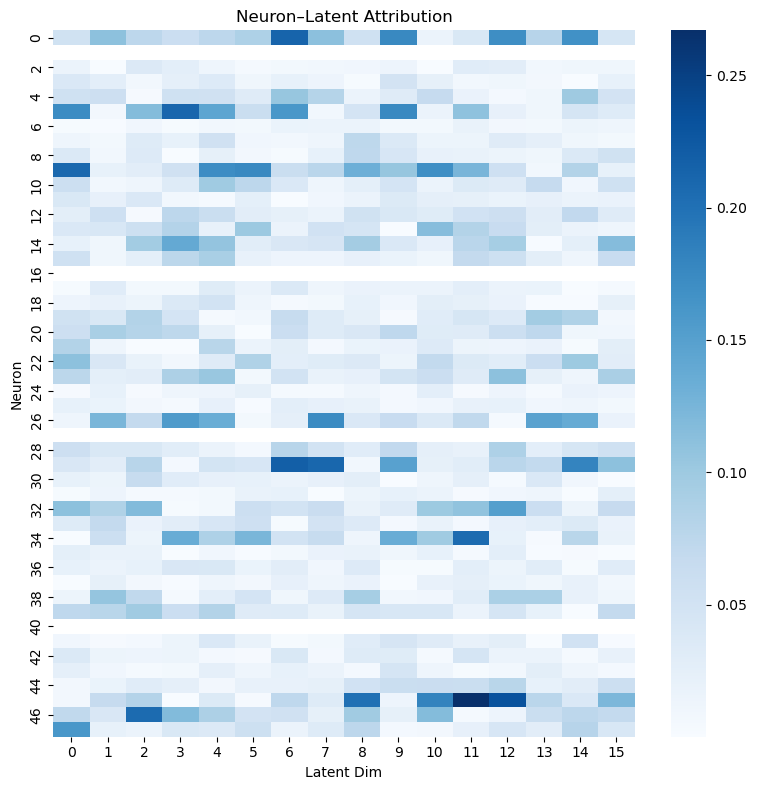

In [8]:
nl_corr = neuron_latent_attribution(neural_train, z_train)

plt.figure(figsize=(8, 8))
sns.heatmap(np.abs(nl_corr), cmap="Blues")
plt.title("Neuron–Latent Attribution")
plt.xlabel("Latent Dim")
plt.ylabel("Neuron")
plt.tight_layout()
plt.show()


Evaluating SAE with topk = 8
[topk=8] Position R2 - train: 0.598, valid: 0.704
[topk=8] Direction acc — train: 0.789, valid: 0.863


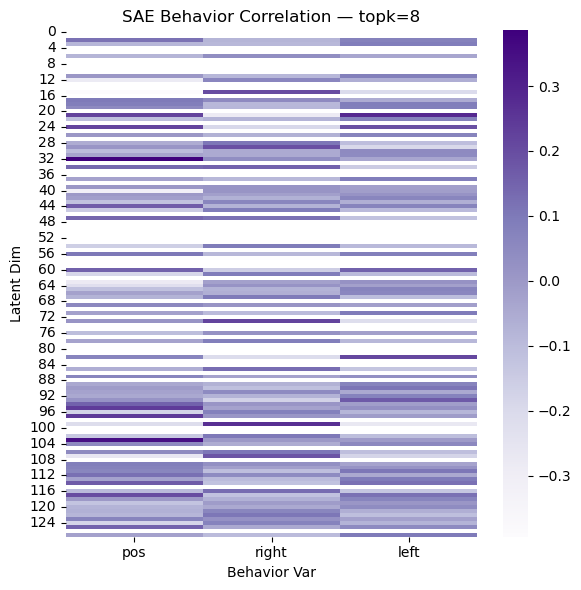

[topk=8] Avg % active dims: 6.2%


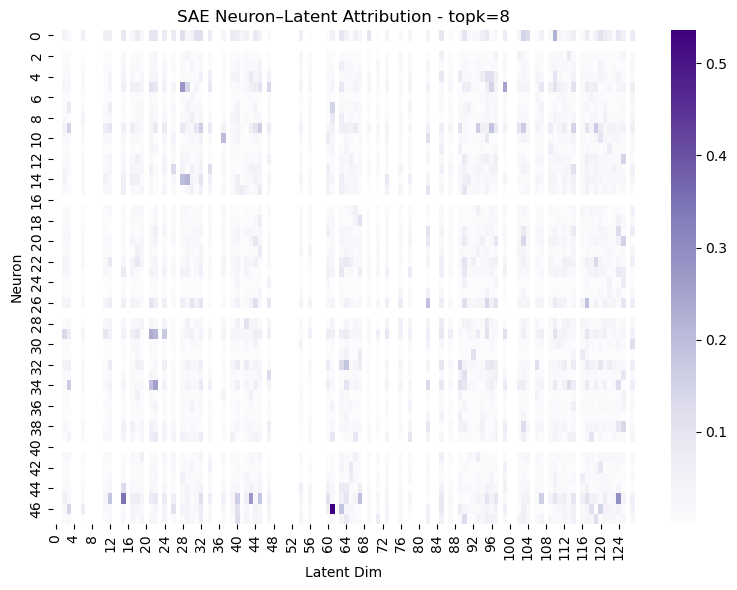


Evaluating SAE with topk = 16
[topk=16] Position R2 - train: 0.613, valid: 0.727
[topk=16] Direction acc — train: 0.786, valid: 0.883


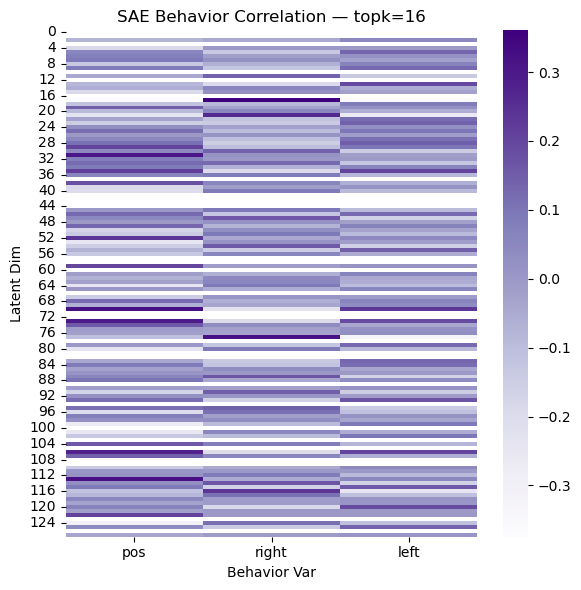

[topk=16] Avg % active dims: 12.5%


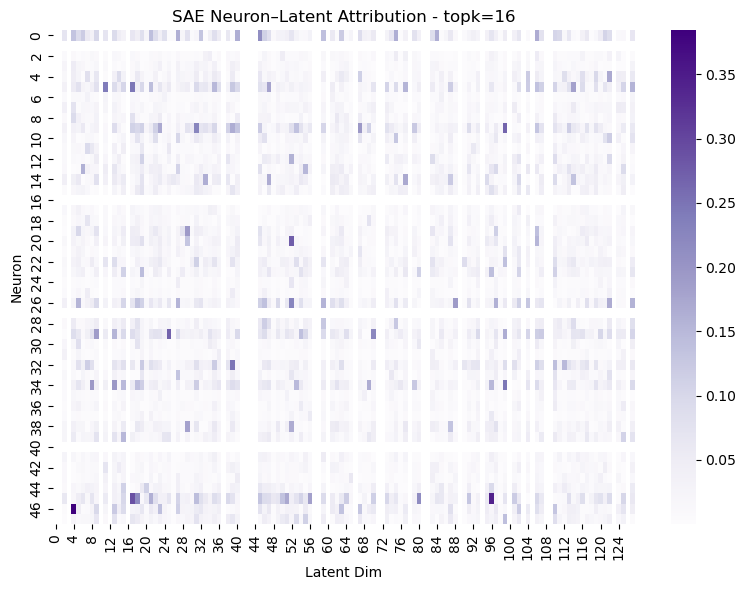


Evaluating SAE with topk = 32
[topk=32] Position R2 - train: 0.655, valid: 0.738
[topk=32] Direction acc — train: 0.789, valid: 0.894


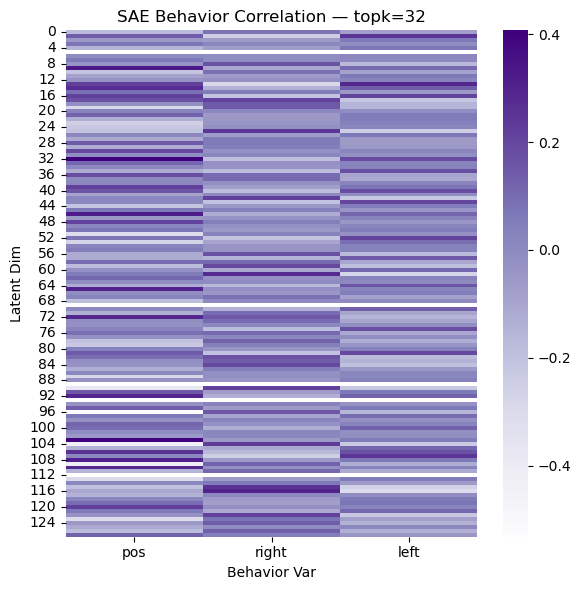

[topk=32] Avg % active dims: 25.0%


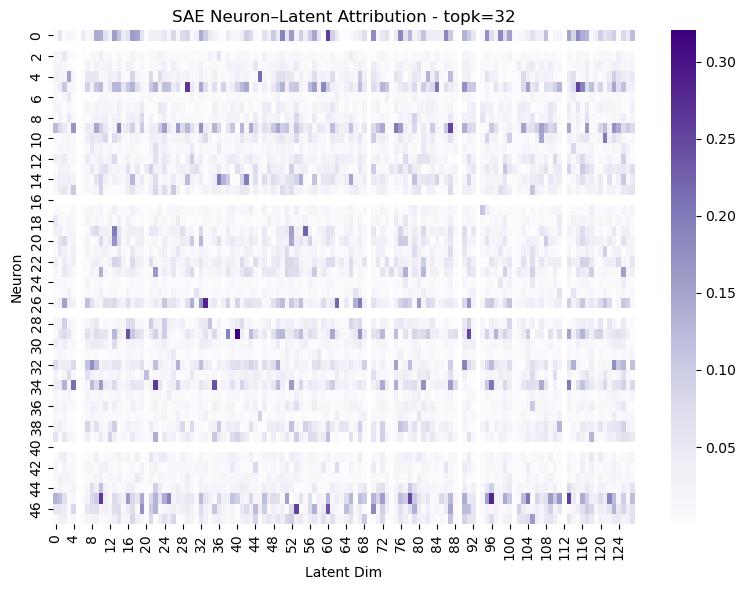

In [9]:
topk_values = [8, 16, 32]
expansion_factor = 8
lr = 1e-3

for topk in topk_values:
    print(f"\nEvaluating SAE with topk = {topk}")


    z_sae_train = get_topk_latents_by_params(
        name=rat,
        dim=embedding_size,
        embedding_array=z_train,
        topk=topk,
        expansion_factor=expansion_factor,
        lr=lr
    )

    z_sae_valid = get_topk_latents_by_params(
        name=rat,
        dim=embedding_size,
        embedding_array=z_valid,
        topk=topk,
        expansion_factor=expansion_factor,
        lr=lr
    )

    r2_train_sae = compute_position_r2(z_sae_train, position_train)
    r2_valid_sae = compute_position_r2(z_sae_valid, position_valid)
    print(f"[topk={topk}] Position R2 - train: {r2_train_sae:.3f}, valid: {r2_valid_sae:.3f}")

    acc_train_sae = compute_direction_acc(z_sae_train, direction_train)
    acc_valid_sae = compute_direction_acc(z_sae_valid, direction_valid)
    print(f"[topk={topk}] Direction acc — train: {acc_train_sae:.3f}, valid: {acc_valid_sae:.3f}")

    corr_sae = compute_behavior_corr(z_sae_train, behavior_train)
    plt.figure(figsize=(6, 6))
    sns.heatmap(corr_sae, cmap="Purples", xticklabels=["pos", "right", "left"])
    plt.title(f"SAE Behavior Correlation — topk={topk}")
    plt.xlabel("Behavior Var")
    plt.ylabel("Latent Dim")
    plt.tight_layout()
    plt.show()

    sparsity_percent_sae = compute_sparsity(z_sae_train)
    print(f"[topk={topk}] Avg % active dims: {sparsity_percent_sae:.1f}%")

    nl_corr_sae = neuron_latent_attribution(neural_train, z_sae_train)
    plt.figure(figsize=(8, 6))
    sns.heatmap(np.abs(nl_corr_sae), cmap="Purples")
    plt.title(f"SAE Neuron–Latent Attribution - topk={topk}")
    plt.xlabel("Latent Dim")
    plt.ylabel("Neuron")
    plt.tight_layout()
    plt.show()